# TCSPC Distance Measurement with the GP22 chip


# Initilization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.neighbors import KernelDensity
from scipy import polyfit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Define some function

In [2]:
# Data pre-prosessing -- Remove zeros
def data_filtering(data, time_filter_range = [0, 500]):
    data1 = []
    for i in list(data):
        if i > time_filter_range[0] and i < time_filter_range[1]:
            data1.append(i)
    return np.array(data1)[:, np.newaxis]

# Define No. Counter function
def number_counter(data):
    counter = {}
    for i in xrange(data.shape[0]):
        if float(data[i]) not in counter:
            counter[float(data[i])] = 1
        else:
            counter[float(data[i])] += 1
    return counter

# Define hist_find_max function
def hist_find_max(data1, hist_color='blue', print_out = True):
    plt.hist(data1, bins=bins, normed=True, color=hist_color, alpha = alpha)
    counter1 = number_counter(data1)
    results1 = sorted(counter1.items(), key = lambda x: x[1], reverse = True)

    # # Weight average
    count_sum = 0
    for i in xrange(weight_avg_no):
        count_sum += results1[i][1]
        if print_out:
            print 'Rank', i + 1, 'of time1(counts):', results1[i][0], '(%d)' % results1[i][1]
    x1 = 0
    for i in xrange(weight_avg_no):
        x1 += results1[i][0] * results1[i][1] / count_sum
    return x1

# Define hist_kde_fitting function
def hist_kde_fitting(data1, hist_color='blue', fit_color = 'red'):
# KDE fit without paramatric bandwidth
    kde1 = sm.nonparametric.KDEUnivariate(data1)
    kde1.fit()
    n1, _, _  = plt.hist(data1, bins=bins, normed=True, color=hist_color, alpha = alpha)
    kde1.density = kde1.density / np.max(kde1.density) * np.max(n1)
    plt.plot(kde1.support, kde1.density, lw=2, color = fit_color)
    # # find max
    return kde1.support[np.argmax(kde1.density)]

## Parameters

In [3]:
bins = 100
alpha = 0.5
weight_avg_no = 5 # Return max time if set weight_avg_no = 1 

## Load Data

In [4]:
file_name = ['500k_5_30cm_1', '500k_5_30cm_2', '500k_5_30cm_3', '500k_5_30cm_4', 
             '500k_5_40cm_1', '500k_5_40cm_2', '500k_5_40cm_3', '500k_5_40cm_4', 
             '500k_5_50cm_1', '500k_5_50cm_2', '500k_5_50cm_3', '500k_5_50cm_4', 
             '500k_5_60cm_1', '500k_5_60cm_2', '500k_5_60cm_3', '500k_5_60cm_4', 
             '500k_5_70cm_1', '500k_5_70cm_2', '500k_5_70cm_3', '500k_5_70cm_4', 
             '500k_5_80cm_1', '500k_5_80cm_2', '500k_5_80cm_3', '500k_5_80cm_4', 
             '500k_5_90cm_1', '500k_5_90cm_2', '500k_5_90cm_3', '500k_5_90cm_4']
data = {}
for name in file_name:
    name0 = './data/' + name + '.txt'
    data0 = np.loadtxt(name0, skiprows=1)
    data[name] = data0

## Raw data and data-preprocessing

Top rankings of raw data:
Rank 1 of time1(counts): -0.004 (2055)
Rank 2 of time1(counts): 70.862 (22)
Rank 3 of time1(counts): 71.037 (20)
Rank 4 of time1(counts): 71.213 (15)
Rank 5 of time1(counts): 71.06 (15)

Top rankings of data after pre-processing:
Rank 1 of time1(counts): 70.862 (22)
Rank 2 of time1(counts): 71.037 (20)
Rank 3 of time1(counts): 71.213 (15)
Rank 4 of time1(counts): 71.06 (15)
Rank 5 of time1(counts): 70.686 (14)


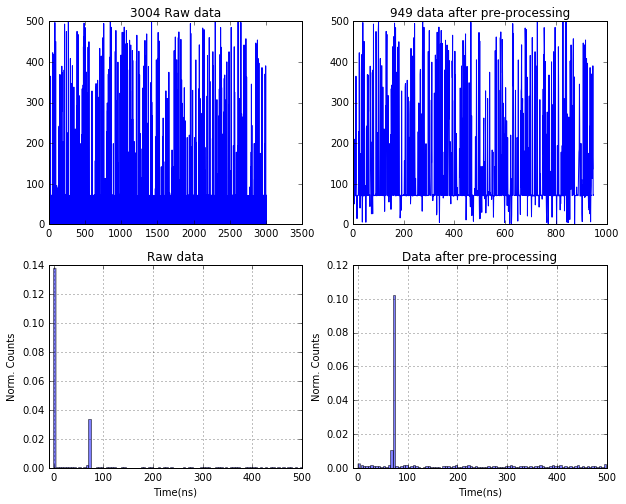

In [5]:
data0 = data['500k_5_30cm_1']

plt.subplot(2,2,1)
plt.plot(data0)
plt.title('%d Raw data' % len(data0))
plt.ylim((0, 500))

plt.subplot(2,2,2)
data1 = data_filtering(data0)
plt.plot(data1)
plt.title('%d data after pre-processing' % len(data1))
plt.ylim((0, 500))

plt.subplot(2,2,3)
print 'Top rankings of raw data:'
x1 = hist_find_max(data0)
plt.xlabel('Time(ns)')
plt.ylabel('Norm. Counts')
plt.title('Raw data')
plt.xlim(-10, 500)
plt.grid(True)

plt.subplot(2,2,4)
print '\nTop rankings of data after pre-processing:'
x1 = hist_find_max(data1)
plt.xlabel('Time(ns)')
plt.ylabel('Norm. Counts')
plt.title('Data after pre-processing')
plt.xlim(-10, 500)
plt.grid(True)

plt.show()


## KDE fitting for data in time range (60, 80)

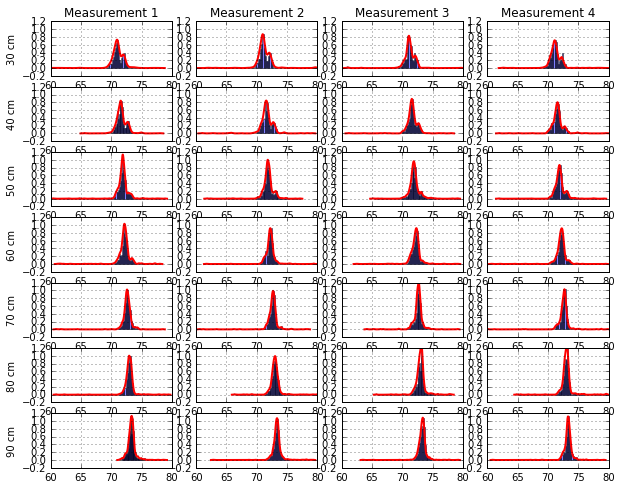

In [6]:
time = {}
for i, name in enumerate(file_name, 1):
    plt.subplot(7, 4, i)
    data1= data_filtering(data[name], time_filter_range = [60, 80])
    time[name] = hist_kde_fitting(data1)
    plt.xlim(60, 80)
    plt.ylim(-0.2, 1.2)
    plt.grid(True)
    if i < 5:
        plt.title('Measurement %d' %i)
    if i % 4 == 1:
        plt.ylabel('%d cm' %(((i - 1) / 4 + 3) * 10))

plt.show()

## Plot of the Measurement Distance 

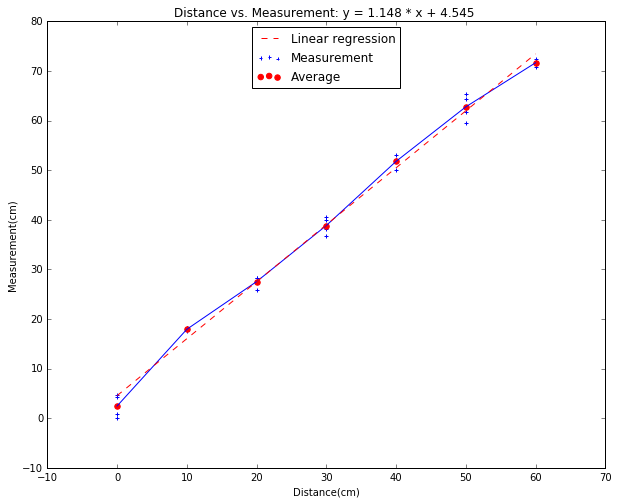

In [7]:
# Normolization
x_scatter = []
x = []
distance = []
distance_mean = []
distance_std = []
for i in xrange(7):
    x_scatter.append([i * 10] * 4)
    x.append([i * 10])

min_name, min_value = min(time.items(), key=lambda x: x[1])

for name in enumerate(file_name):
    distance.append((time[name[1]] - min_value) * 30)
    
for i in xrange(7):
    distance_mean.append(np.mean(distance[i * 4: (i + 1) * 4]))

plt.scatter(x_scatter, distance, label = 'Measurement', marker='+', s = 10)
plt.scatter(x, distance_mean, label = 'Average', color = 'red', s = 30)   
plt.plot(x, distance_mean)

x = np.squeeze(x)
ar, br = polyfit(x, distance_mean, 1)

x0 = [0, 60]
y0 = [br, x0[1] * ar + br]
plt.plot(x0, y0, 'r--', label = 'Linear regression')

plt.legend(loc='upper center')
plt.xlabel('Distance(cm)')
plt.ylabel('Measurement(cm)')
plt.title('Distance vs. Measurement: y = %.3f * x + %.3f ' % (ar, br))
plt.show()

## Measurement under noisy environment

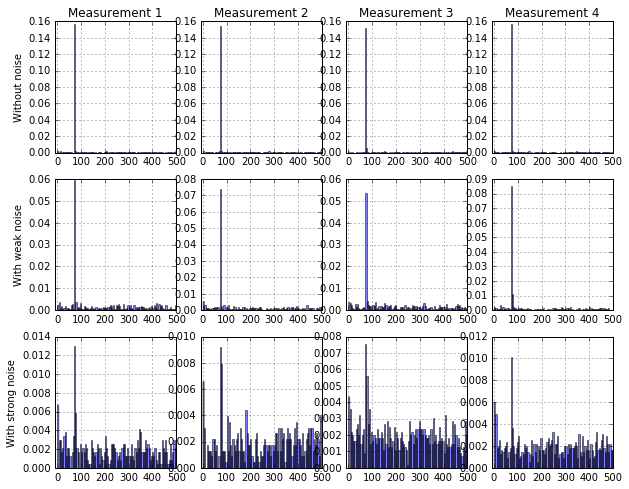

In [8]:
# Load data
file_name_noise = ['500k_5_90cm_weak_light_1', '500k_5_90cm_weak_light_2', 
                   '500k_5_90cm_weak_light_3', '500k_5_90cm_weak_light_4', 
                   '500k_5_90cm_strong_light_1', '500k_5_90cm_strong_light_2',
                   '500k_5_90cm_strong_light_3', '500k_5_90cm_strong_light_4']
data_noise = {}
for name in file_name_noise:
    name0 = './data/' + name + '.txt'
    data0 = np.loadtxt(name0, skiprows=1)
    data_noise[name] = data0
    
# Without noise
for i in xrange(4):
    name = '500k_5_90cm_' + str(i + 1)
    data0 = data[name]
    data1 = data_filtering(data0)
    plt.subplot(3, 4, i + 1)
    x1 = hist_find_max(data1, print_out = False)
    plt.title('Measurement %d' %(i + 1))
    if i == 0:
        plt.ylabel('Without noise')
    plt.xlim(-10, 500)
    plt.grid(True)

# With weak noise
for i in xrange(4):
    name = '500k_5_90cm_weak_light_' + str(i + 1)
    data0 = data_noise[name]
    data1 = data_filtering(data0)
    plt.subplot(3, 4, i + 5)
    x1 = hist_find_max(data1, print_out = False)
    if i == 0:
        plt.ylabel('With weak noise')
    plt.xlim(-10, 500)
    plt.grid(True)
    
# With strong noise
for i in xrange(4):
    name = '500k_5_90cm_strong_light_' + str(i + 1)
    data0 = data_noise[name]
    data1 = data_filtering(data0)
    plt.subplot(3, 4, i + 9)
    x1 = hist_find_max(data1, print_out = False)
    if i == 0:
        plt.ylabel('With strong noise')
    plt.xlim(-10, 500)
    plt.grid(True)